In [48]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [49]:
from keras.layers import InputLayer, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [50]:
#Replace max pool with average pool as avg pool retains more information
def maxpool_to_avgpool(shape):
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    new_model = Sequential()
    new_model.add(InputLayer(input_shape=shape))
    for layer in vgg.layers:
         if(layer.__class__ == MaxPooling2D):
            new_model.add(AveragePooling2D())
         else:
            new_model.add(layer)
    return new_model

In [51]:
# Gram matrix to find the relation between different filters or features detected by the layers
def gram_matrix(img):
    #Input is H,W,C 
    #We have to change this to C,H*W
    #batch flatten leaves the first dimension and flatten the rest (3D->2D)
    x = K.batch_flatten(K.permute_dimensions(img, (2,0,1)))
    G = K.dot(x, K.transpose(x))/img.get_shape().num_elements()
    return G

In [52]:
#It takes the style and target image and calculates J(style)
def style_loss(y,t):
    return K.mean(K.square(gram_matrix(y)-gram_matrix(t)))

In [53]:
def minimize(fn,epochs,batch_shape):
    loses=[]
    x = np.random.randn(np.prod(batch_shape)) #Initialize a random image
    from scipy.optimize import fmin_l_bfgs_b
    for i in range(20):
        x,l,_ = fmin_l_bfgs_b(func=fn, x0=x, maxfun=20)
        x=np.clip(x,-127,127)
        print("iter=%s loss=%s" % (i,l))
        loses.append(l)
    plt.plot(loses)
    plt.show()
    new_img = x.reshape(batch_shape)
    return new_img[0] #since it also has batch shape we will omit that by returning new_img[0]

In [54]:
import keras.backend as K

In [55]:
if __name__ == '__main__':
    size=(300,300)
    path=r'C:\Users\KIIT\Desktop\Projects\Style_transfer\Style.jpg'
    img = Image.open(path)
    img=img.resize(size)
    x=np.asarray(img)
    #We have to expand dimension as model takes input in form of batches(1,H,W,C)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    batch_shape = x.shape
    shape = x.shape[1:] #Omit the batch size
    vgg = maxpool_to_avgpool(shape)
    symbolic_output = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]
    multi_output_model = Model(vgg.input, symbolic_output)
    style_out = [K.variable(y) for y in multi_output_model.predict(x)]
    
    loss=0
    for symbolic, actual in zip(symbolic_output, style_out):
        loss+=style_loss(symbolic[0], actual[0])
    grads = K.gradients(loss, multi_output_model.input)
    get_loss_grads = K.function(inputs=[multi_output_model.input], outputs=[loss]+grads)
    def loss_and_grads_wrapper(x_vec):
        l,g = get_loss_grads([x_vec.reshape(batch_shape)])
        return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0 loss=4932.43212890625
iter=1 loss=313.2057189941406
iter=2 loss=145.13536071777344
iter=3 loss=100.38478088378906
iter=4 loss=77.27611541748047
iter=5 loss=61.83021545410156
iter=6 loss=46.72596740722656
iter=7 loss=36.23008728027344
iter=8 loss=27.819744110107422
iter=9 loss=22.103635787963867
iter=10 loss=18.242897033691406
iter=11 loss=14.450455665588379
iter=12 loss=11.965753555297852
iter=13 loss=10.2726469039917
iter=14 loss=8.955570220947266
iter=15 loss=7.986413955688477
iter=16 loss=7.151014804840088
iter=17 loss=6.355443000793457
iter=18 loss=5.818400859832764
iter=19 loss=5.372403621673584


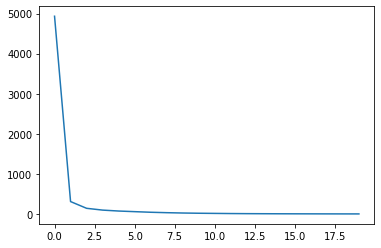

In [56]:
final_img = minimize(loss_and_grads_wrapper, 10, batch_shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


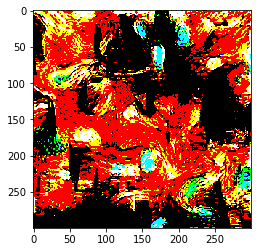

In [57]:
plt.imshow(final_img)
plt.show()

In [58]:
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale(x):
    x = x-x.min()
    x=x/x.max()
    return x

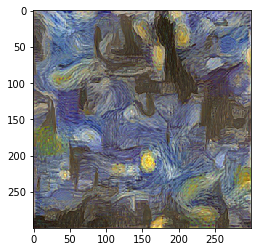

In [61]:
img = unpreprocess(final_img)
plt.imshow(scale(img))